# Ensambles - Bagging

A lo largo del notebook vamos a trabajar con el siguiente dataset:

https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

El objetivo de este analisis será predecir si lloverá o no al día siguiente.

## 1. EDA y Preprocesamiento

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.tree import DecisionTreeClassifier

import sklearn.metrics as metrics
from sklearn.model_selection import learning_curve
#Extras
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Abrir el dataset

In [3]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DS_Bitácora_27_Weather.csv")
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


Contamos cuántos valores no-nulos hay

In [4]:
data.count().sort_values()

Sunshine          74377
Evaporation       81350
Cloud3pm          85099
Cloud9am          88536
Pressure9am      128179
Pressure3pm      128212
WindDir9am       132180
WindGustDir      132863
WindGustSpeed    132923
WindDir3pm       138415
Humidity3pm      138583
Temp3pm          139467
WindSpeed3pm     139563
Humidity9am      140419
RainToday        140787
Rainfall         140787
WindSpeed9am     140845
Temp9am          141289
MinTemp          141556
MaxTemp          141871
Date             142193
Location         142193
RISK_MM          142193
RainTomorrow     142193
dtype: int64

2. Tirar las columnas que no nos interesan, entre ellas las que tienen pocos datos (menos de cien mil). Además, tirar 'Location' y 'Date', ya que no nos interesa el lugar ni fecha (al menos en este análisis), y 'RISK_MM', porque es un *leak*. **Para googlear**: ¿qué es un leak?


https://www.kaggle.com/danaelisanicolas/data-cleaning
 if we're focusing on solving this problem as a classification problem, we must drop the 'RISK_MM' as it leaks out the information in predicting our target variable 'RainTomorrow'.
https://www.kaggle.com/lauriandwu/will-it-rain-tomorrow-eda-classification
 RISK_MM: The amount of next day rain in mm. Used to create response variable RainTomorrow. A kind of measure of the "risk". Will be left out in the model.

In [5]:
columnas_descartables = ['Sunshine','Evaporation','Cloud3pm','Cloud9am','Location','Date', 'RISK_MM']
data = data.drop(columns=columnas_descartables)
data.shape

(142193, 17)

3. Tirar todas las filas que tengan valores nulos.

In [6]:
data = data.dropna()
data.head()


,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No
2,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No
3,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No
4,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No


4. Para simplificar el preprocesamiento, también tirar todas las columnas que tengan valores categóricos. ¿Por qué no nos molesta tirar 'RainToday'?

In [7]:
columnas_descartables = ['WindDir9am','WindDir3pm','WindGustDir']

data = data.drop(columns=columnas_descartables)
data.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No
2,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No
3,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No
4,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No


5. Realizar un countplot para ver cuántos casos hay de lluvia y no-lluvia.

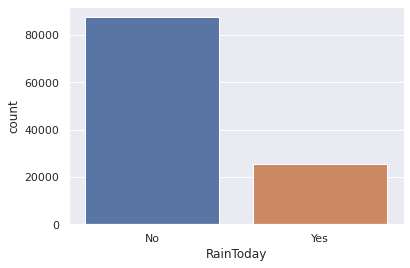

In [8]:
sns.countplot(data.RainToday)
plt.show()

Y hacer el `pairplot` para ver cómo se relacionan las variables. Recuerden que este gráfico puede llevar bastante tiempo. También recuerden que pueden agrandar el gráfico haciendo doble click en él.

KeyboardInterrupt: ignored

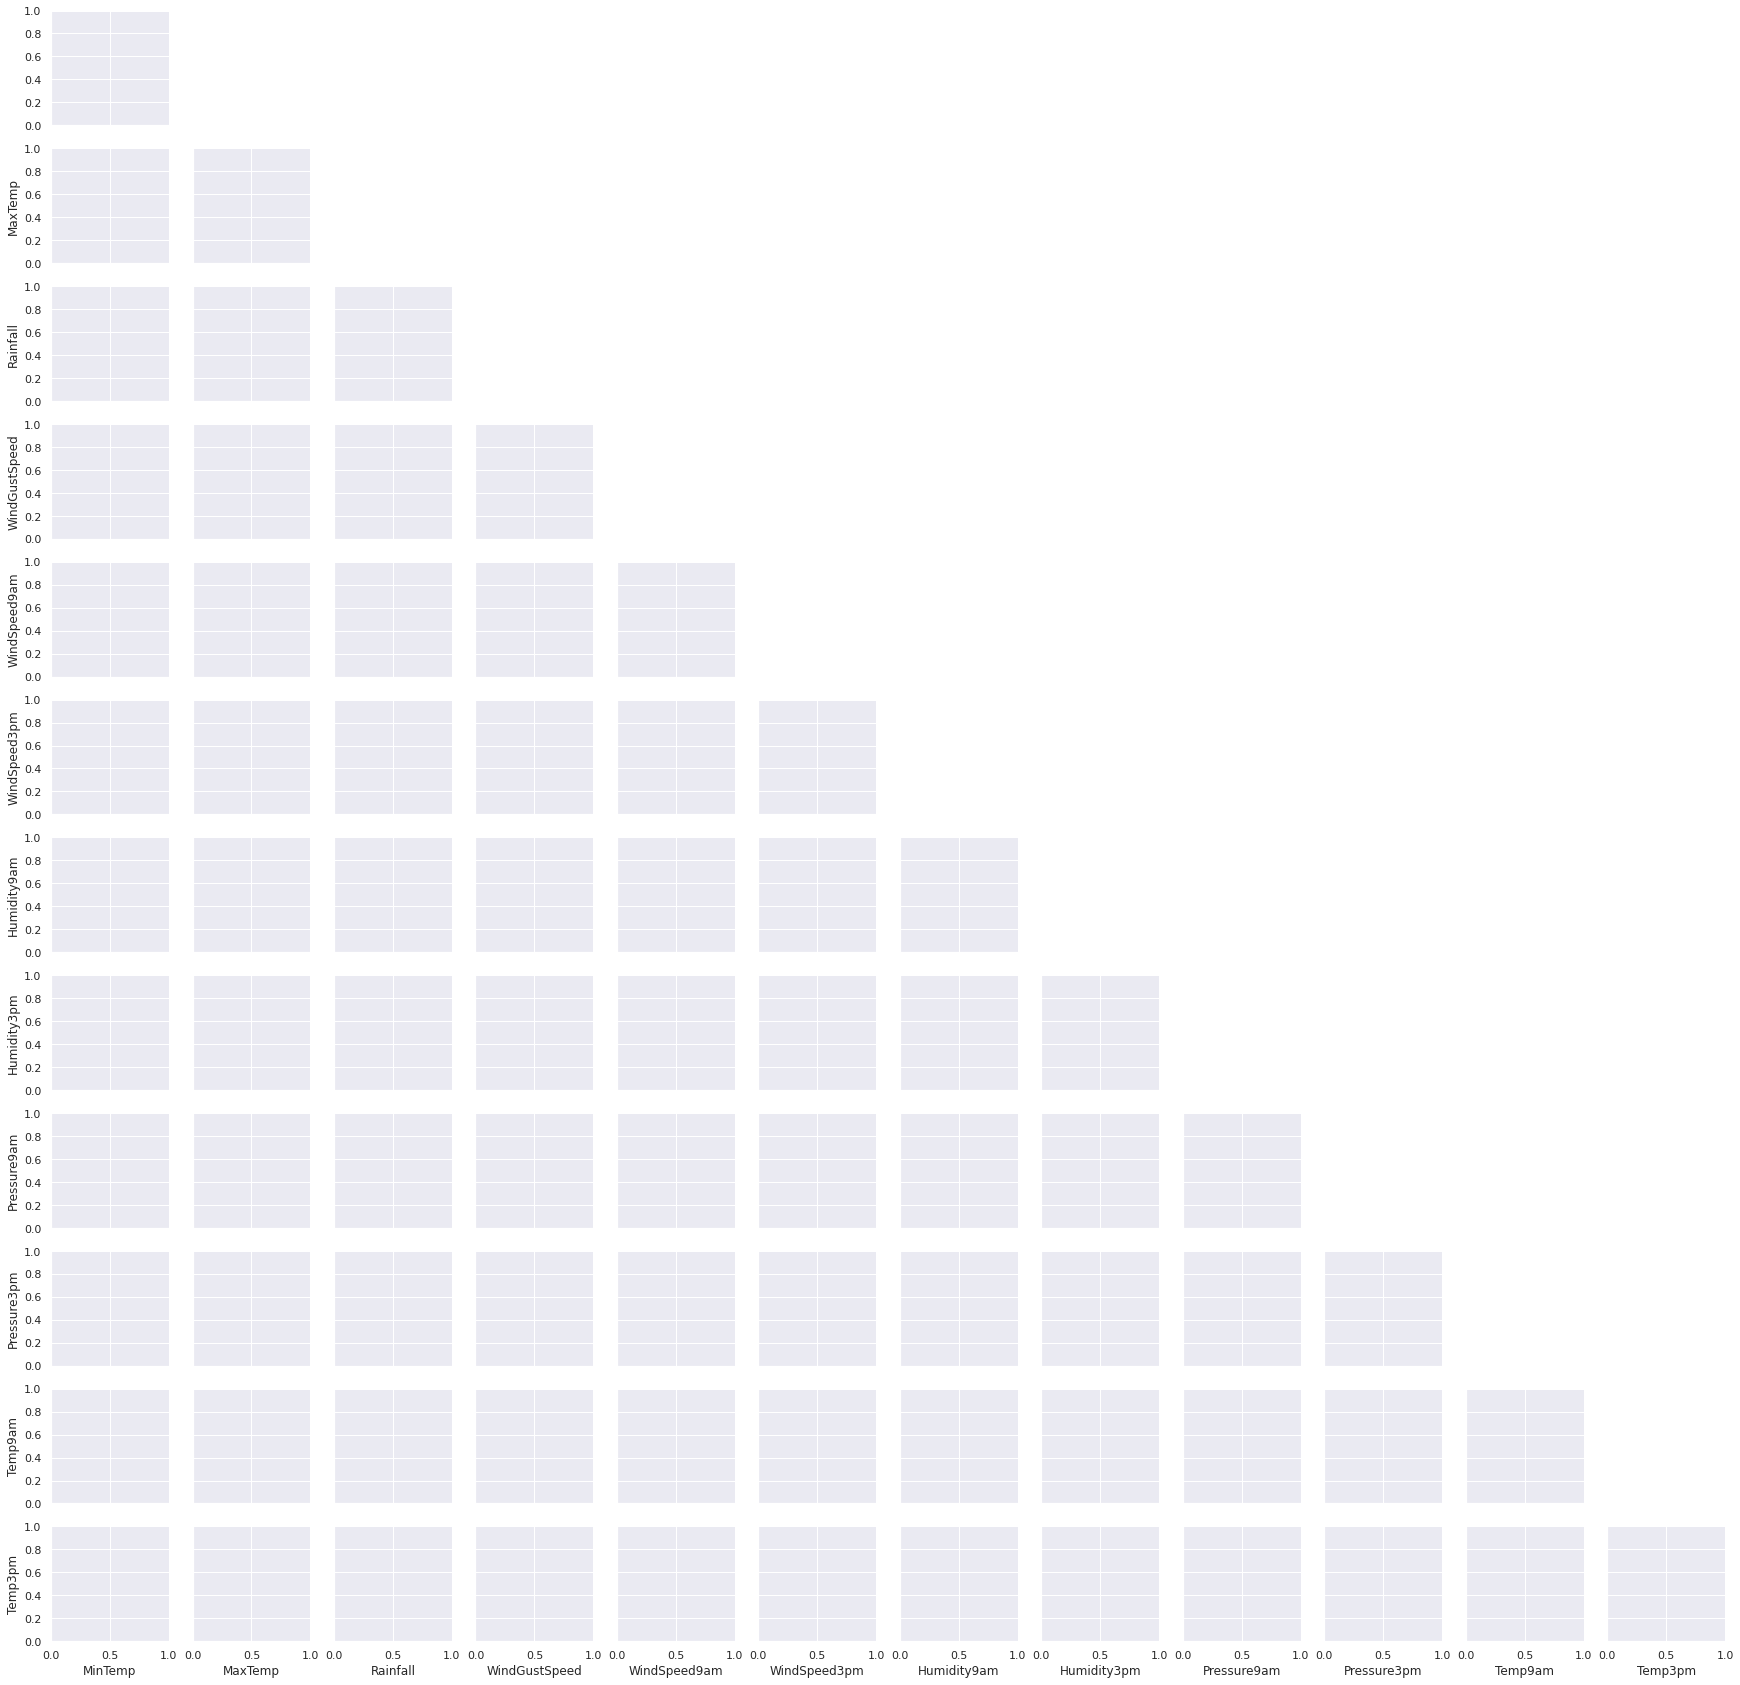

In [ ]:
sns.pairplot(data.sample(frac = 0.1), hue = 'RainTomorrow', corner=True)

Hay algunas que parecen *correlacionadas*. Tratamos de cuantificarlo.

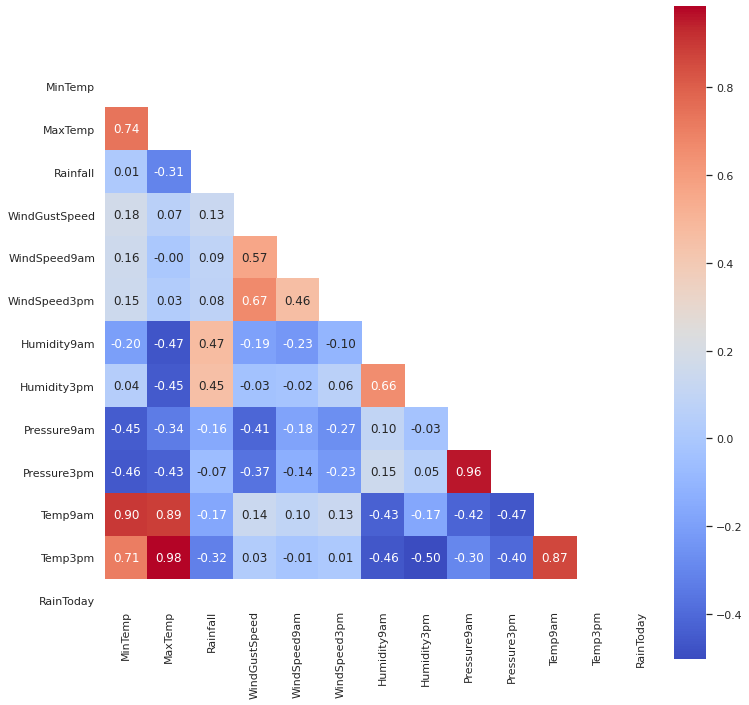

In [ ]:
corr = data.drop(columns = ['RainTomorrow']).corr(method='spearman') # .corr is used for find corelation

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 12},
           xticklabels= data.drop(columns = ['RainTomorrow']).columns, 
           yticklabels= data.drop(columns = ['RainTomorrow']).columns,
           cmap= 'coolwarm',mask=mask)

plt.show()

En base a la correlación, podemos descartar (o no) algunas variables. **Para pensar**, ¿por qué haríamos (o no) esto? 

In [9]:
#las variables de humedad estan correlacionadas con la lluvia de hoy
#las de temperatura de 3 y 9 estan altamente correlacionada.
# y presion 3 a 9 que dan informacion adicional.
data = data.drop(columns=['Pressure3pm', 'Temp9am','RainToday'])

6. Llevar `RainTomorrow` a una variable númerica

In [10]:
data['RainTomorrow'] = data['RainTomorrow'].map(lambda x: 1 if(x=='Yes') else 0)
#df['RainTomorrow'] = df['RainTomorrow'].apply(lambda x: 1 if(x=='Yes') else 0)
# Adjusting the Target Variables' values: Yes/No with 1/0
#df_ML = df_ML.replace({'RainTomorrow':'Yes','RainToday':'Yes'},1)
#df_ML = df_ML.replace({'RainTomorrow':'No','RainToday':'No'},0)

data.head()
Data=data

### Datos de entrenamiento y casos *benchmark*

Generamos casos base contra los cuales comparar nuestros resultados.

1. Elegir variables de entrenamiento (empezar con dos) y separar las etiquetas

In [11]:
#columnas_entrenamiento = ['Rainfall','MinTemp','MaxTemp','Humidity3pm']
columnas_entrenamiento = ['MaxTemp','Humidity3pm']
X = Data[columnas_entrenamiento]
y = Data.RainTomorrow

2. Generar un modelo que diga siempre que NO va a llover y medir su exactitud.

In [12]:
#Todos Ceros
y_pred = np.zeros(y.shape)
accuracy_ceros = metrics.accuracy_score(y,y_pred)
print(accuracy_ceros) #las etiquetas estan más prefiriendo no lluvia que lluvia por lo que el sesgo para un modelo simple 
#dara mejor para casos de no lluvia

0.7784458711534205


Y generar otro modelo que diga siempre que va a llover y medir su exactitud.

In [13]:
#Todos Unos
y_pred = np.ones(y.shape)
accuracy_unos = metrics.accuracy_score(y,y_pred)
print(accuracy_unos)

0.2215541288465796


**3. - Challenge:**  Entrena un árbol de decisión sobre este dataset. Intenta obtener el mejor desempeño que creas posible, optimizando sus hiperparámetros. 

estefi uso grid search y randomsearch. 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)

    Depth  Acc_test   F1_test  ...  F1_train  Ps_train  Rs_train
0       1  0.824488  0.835464  ...  0.833809  0.851407  0.822928
1       2  0.827292  0.862422  ...  0.861428  0.928533  0.826432
2       3  0.830214  0.852778  ...  0.851710  0.894622  0.829102
3       4  0.830126  0.857615  ...  0.856715  0.909712  0.829304
4       5  0.830952  0.854312  ...  0.852953  0.896812  0.830000
5       6  0.832458  0.855203  ...  0.853803  0.897034  0.831290
6       7  0.832281  0.855015  ...  0.854161  0.897219  0.831784
7       8  0.830657  0.854040  ...  0.855967  0.900018  0.833302
8       9  0.829535  0.852950  ...  0.856690  0.899850  0.834579
9      10  0.828148  0.849561  ...  0.856337  0.895488  0.836224
10     11  0.826731  0.851027  ...  0.860791  0.905943  0.838198
11     12  0.824045  0.846657  ...  0.861948  0.903291  0.841411
12     13  0.821389  0.845043  ...  0.864942  0.907565  0.844156
13     14  0.821034  0.842853  ...  0.866089  0.905423  0.847015

[14 rows x 9 columns]


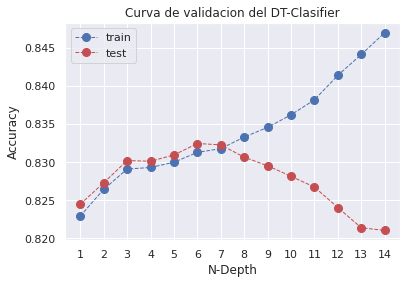

In [ ]:
from sklearn.tree import  DecisionTreeClassifier
from sklearn.metrics import  accuracy_score,f1_score,precision_score,recall_score

def get_score_DT(max_depth,train_x,test_x,train_y,test_y):
    clf_tree= DecisionTreeClassifier(max_depth=max_depth,random_state=20)
    # Entrenar el modelo    
    clf_tree.fit(X_train,y_train)
    #calculo los scores para los datos test
    # Predecir y evaluar sobre el set de testeo    
    preds_test=clf_tree.predict(X_test)
    ACC_test=accuracy_score(preds_test,y_test)
    f1_test=f1_score(preds_test,y_test,average='weighted')
    ps_test=precision_score(preds_test,y_test,average='weighted')
    rs_test=recall_score(preds_test,y_test,average='weighted')
    #calculo los scores para los datos train
    # Predecir y evaluar sobre el set de entrenamiento
    preds_train=clf_tree.predict(X_train)
    ACC_train=accuracy_score(preds_train,y_train)
    f1_train=f1_score(preds_train,y_train,average='weighted')
    ps_train=precision_score(preds_train,y_train,average='weighted')
    rs_train=recall_score(preds_train,y_train,average='weighted')
    return max_depth,  ACC_test, f1_test, ps_test, rs_test,ACC_train, f1_train, ps_train, rs_train


ScoreDT=[]
#veo los scores para set de datos con DT
for max_depth in range(1,15):
    my_scores_DT=get_score_DT(max_depth,X_train,X_test,y_train,y_test)  
    ScoreDT.append(list(my_scores_DT))


ScoreDT=pd.DataFrame(ScoreDT,columns=['Depth','Acc_test','F1_test','Ps_test','Rs_test','Acc_train','F1_train','Ps_train','Rs_train']) #muestra lista del acc en funcion de la prof del arbol
print(ScoreDT)
ScoreDT.shape


#Accuracy
plt.figure()
plt.plot(ScoreDT["Depth"].values,ScoreDT["Acc_train"].values,color='b', marker='o', linestyle='dashed',linewidth=1, markersize=8,label='train' )
plt.plot(ScoreDT["Depth"].values,ScoreDT["Acc_test"].values,color='r', marker='o', linestyle='dashed',linewidth=1, markersize=8,label='test')
plt.legend()
plt.xticks(ticks=ScoreDT["Depth"].values)
plt.xlabel('N-Depth')
plt.ylabel('Accuracy')
plt.title('Curva de validacion del DT-Clasifier')
plt.show()

El mejor hiperparametro sería maxdepth 3 para 4  features. 6 para 2 features

## 2. Bagging

Separamos entre train y test

In [15]:
columnas_entrenamiento = ['MaxTemp','Humidity3pm']
X = data[columnas_entrenamiento]
y = data.RainTomorrow
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)

Recuerden que el objetivo de bagging es entrenar distintos modelos, donde cada uno vea distintas porciones del set de entrenamiento. Entonces, vamos a entrenar distintos árboles de decisión y mostrarles distintas porciones del set de datos. Lo vamos a hacer en un `for`.

1. Crear una lista vacía donde guardaremos los modelos entrenados y elegir cuántos modelos entrenar (Empezar por algún valor entre 5 y 10).

In [20]:
lista_de_modelos = [] #guardo los modelos
N_modelos = 7 #entremo modelos en paralelos

2. Entrenar cada modelo y guardar cada modelo entrenado en una lista. Para hacer el split, usar la función `train_test_split`. ¿Sobre qué conjunto van a hacer el split?

¿Hay que fijar el `random_state`?
 No hay que fijar el random para dejar libre un muestreo al azar (el random lo va a ir modificando)

In [21]:
for i in range(N_modelos):
    X_train_boostrap, _, y_train_boostrap, _ = train_test_split(X_train, y_train, test_size=0.5, stratify = y_train) #no interesa guardar un set de test(ya lo tengo antes), solo quiero simular las submuestras. una variable _ quiere decir que no lo guarde en ninguna variable.
    #stratify hace una conservacion de relación de clases. 
    clf = DecisionTreeClassifier(max_depth = None)#esto me dice que es maxima profundidad del arbol #Notar que lo dejamos overfitear
    #¿que modelo pongo para el ensamble? para hacer el baggin parto de modelos overfitteados<--hipotesis
    clf.fit(X_train_boostrap, y_train_boostrap)
    lista_de_modelos.append(clf)

3. Evaluar el accuracy de cada modelo usando el conjunto de held_out

In [22]:
for idx, modelo in enumerate(lista_de_modelos):
    y_test_pred = modelo.predict(X_test)
    print('Accuracy Modelo ', idx, ' es ', metrics.accuracy_score(y_test, y_test_pred))

Accuracy Modelo  0  es  0.7908672294704528
Accuracy Modelo  1  es  0.7913395123679083
Accuracy Modelo  2  es  0.7944979042446425
Accuracy Modelo  3  es  0.7902768758486334
Accuracy Modelo  4  es  0.7920184190330007
Accuracy Modelo  5  es  0.7943207981580968
Accuracy Modelo  6  es  0.7913985477300903


In [23]:
for idx, modelo in enumerate(lista_de_modelos):
    y_train_pred = modelo.predict(X_train)
    print('Accuracy Modelo ', idx, ' es ', metrics.accuracy_score(y_train, y_train_pred))

Accuracy Modelo  0  es  0.8364643819499791
Accuracy Modelo  1  es  0.8396017559173656
Accuracy Modelo  2  es  0.8377294520981189
Accuracy Modelo  3  es  0.8381342745455236
Accuracy Modelo  4  es  0.837640897187749
Accuracy Modelo  5  es  0.838627651903298
Accuracy Modelo  6  es  0.837514390172935


Parecen estar un poco overfitteados, que era lo que esperábamos.

partimos de la hipotesis que es overfiteado. por un lado el test me da del orden del benchmark. y el acc del es mas alto. 
hay que ver el gap entre ellos.. si aumenta la complejidad tengo que ver como se modifica la metrica con los test y train.

-para ver una mejora el acc del test deberia subir

(escuchar lo que dijo estefi)

4. Evaluar el accuracy de todo el ensamble usando el conjunto de held_out. Vamos a hacerlo usando un promedio de las probabilidades que devuelven cada árbol. Si la probabilidad promedio es mayor a 0.5, clasificamos como positivo. Para ello:
    1. Inicializar un arreglo de probabilidades del tamaño de la cantidad de instancias del conjunto de test en ceros.

In [24]:
#hago la predicción del ensamble. sumo la probabilidad de cada modelo para la clasificacion y promediarlo.

probs_test_pred = np.zeros(y_test.size)

B. Recorrer la lista de modelos y predecir las probabilidades. Mirar como es el `shape` de ese arreglo predicho. Elegir las probabilidades que correspondan a la clase positiva. Luego, sumarlas al vector que definieron antes.

In [25]:
for modelo in lista_de_modelos:
    probs_test_pred_modelo = modelo.predict_proba(X_test)
    print(probs_test_pred_modelo.shape)#miro en cada modelo el predicproba (no quiero que me devuelva la etiqueta sino el score de cuanto espero ) dos columnas, me da en una la probabilidad de clase 1 y en otra d ela clase 0

    # Cuando esten seguros de lo que quieran sumar, descomentar la linea de abajo y completar
    probs_test_pred +=probs_test_pred_modelo[:,1] #tomo la etiqueta 1, quiero sumar la proba de etiqueta 1
  
#no queres solo las etiquetas sino cuan seguro estas de esa etiqueta. por eso hace esto.
#lo que nos interesa es solo la etiqueta de 1
    

(33878, 2)
(33878, 2)
(33878, 2)
(33878, 2)
(33878, 2)
(33878, 2)
(33878, 2)


C. Dividir `probs_test_pred` por la cantidad de modelos

In [26]:
probs_test_pred = probs_test_pred/N_modelos  #promedio de 10 modelos de arbol de descicion.
#aca se hace la votación de todos los modelos

D. Crear las clases predichas (0s y 1s) a partir de comparar la probabilidad predicha con la probabilidad umbral (0.5).

In [27]:
y_test_pred = probs_test_pred>0.5 #para todas las instancia mayor a 0,5 decime que va a llover TRUE
#es una mascara. devuleve booleanos
print(y_test_pred)
y_test_pred = y_test_pred.astype(int) #pasa de booleano a integer.
print(y_test_pred)

[False False False ... False False False]
[0 0 0 ... 0 0 0]


Y evaluar la exactitud de todo el ensamble

In [28]:

print('Accuracy Ensambe ', metrics.accuracy_score(y_test, y_test_pred))
#en el test subio el acuraccy respecto de los arboles individuales. 
#la idea mejora, se trabaja con pocos atributos.
#es suficiente? depende de lo que quiera hacer yo respecto al tema. el costo computacional que implica esto vale la pena?

Accuracy Ensambe  0.8001652990141095


5. Explorar el `BagginClassfier` de scikit-learn y algunas de sus características. Usarlo para predecir sobre el train y test, y medir su desempeño.

In [29]:
#lo anterior serian los pasos que hace el modulo siguiente
from sklearn.ensemble import BaggingClassifier

In [31]:
clf = BaggingClassifier(base_estimator=None, bootstrap = True, bootstrap_features=False, n_estimators = 100, n_jobs = -1)
# If None, then the base estimator is a decision tree
#bootstrap_features seleccion al azar de los atributos  (usamos false para baggin puro). para comparar con randomforest
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print(metrics.accuracy_score(y_train, y_train_pred))
print(metrics.accuracy_score(y_test, y_test_pred))



0.8631573620757271
0.8034122439341166


6. Si usaron dos features, pueden graficar las fronteras de decisión

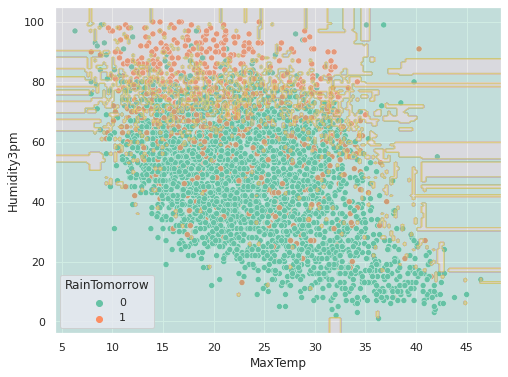

In [ ]:
N = 10 #para no graficar todos los puntos y saturar el grafico

plt.figure(figsize = (8,6))
#Grafico Clasificador Sesgado
ax = sns.scatterplot(X_test[::N].MaxTemp, X_test[::N].Humidity3pm, hue=y_test[::N], palette='Set2')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                      np.linspace(*ylim, num=200))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
contours = ax.contourf(xx, yy, Z, alpha=0.3, cmap = 'Set2')

plt.show()

#apuntamos a que este menos ajustado, las fronteras seran distintas

## 3. Random Forest

Random Forest, además de aplicar Bagging, también selecciona features al azar, de esa manera descorrelaciona aún más los distintos modelos de árbol creados.

1. Importar de scikit-learn el modelo `RandomForestClassifier`

In [34]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report

In [64]:
columnas_entrenamiento = ['MaxTemp','Humidity3pm']
#le voy a dar a randomforest pocos atributos, entonces no podria hacer selecionar features muchos.
#por eso tengo que ponerle muchos features para explotar la calidad del randomforest 
X = Data[columnas_entrenamiento]
y = Data.RainTomorrow
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)

2. Investigar sus parámetros. En particular, `n_estimators`, `max_features` y `oob_score`. Luego, crear y entrenar un modelo en el conjunto de train.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#sklearn.ensemble.RandomForestClassifier

**n_estimators** The number of trees in the forest.

**max_features** The number of features to consider when looking for the best split

**oob_scorebool** Whether to use out-of-bag samples to estimate the generalization accuracy.


In [65]:
clf = RandomForestClassifier(n_estimators=10, max_features='auto', n_jobs=-1, oob_score = True, random_state = 42)
clf.fit(X_train,y_train)
#sqrt= es lo recomendado para un problema de clasificacion
#max_features aca selecciona la importancia del feature. y ademas hace bootstrap

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

3. Evaluar su desempeño en el conjunto de train y de test.

In [68]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_train_pred, y_train))
print(metrics.accuracy_score(y_test_pred, y_test))

0.8604374612572268
0.8004899935061102


4. ¿Cuál es su `oob_score_`?¿Y que son `feature_importances_`?

In [69]:
clf.oob_score_  #out of bag score. agrega esta predicción para evaluar la performance en el modelo.
#ver clase

0.7938188672561893

In [70]:
clf.feature_importances_   #la importancia de los features

array([0.42948551, 0.57051449])

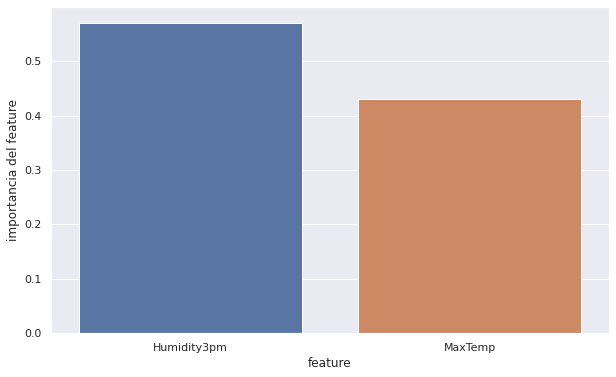

In [71]:
# CORRER ESTA CELDA UNA VEZ QUE HAYAN ESTUDIADO QUE ES OOB_SCORE Y FEATURE_IMPORTANCES
#se grafica lo que devuelve el feature_importance
importances = clf.feature_importances_
columns = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize = (10,6))
sns.barplot(columns[indices], importances[indices])
plt.xlabel('feature')
plt.ylabel('importancia del feature')
plt.show()

5. ¿Qué hay en la propiedad `estimators_`?

In [72]:
clf.estimators_ #muestra los distintos arboles que se usaron en el bosque

[DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=1608637542, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=1273642419, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, 

6. Elegir uno de los `estimators` y evaluar su desempeño sobre train y test.

In [73]:
#puedo generar mis arboles de clasificación .
clf_tree = clf.estimators_[0] #veo cada arbol del ensamble
clf_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 1608637542,
 'splitter': 'best'}

In [74]:
#aca obtengo los accuracy del ensamble

y_train_pred = clf_tree.predict(X_train) #acc un arbol
y_test_pred = clf_tree.predict(X_test)#acc un arbol
print(metrics.accuracy_score(y_train, y_train_pred))
print(metrics.accuracy_score(y_test, y_test_pred))

print(metrics.classification_report(y_test, y_test_pred))

#acc train randomforest 0.8604374612572268
#acc train randomforest 0.8004899935061102

0.840664414841803
0.7887419564319027
              precision    recall  f1-score   support

           0       0.84      0.91      0.87     26372
           1       0.53      0.37      0.44      7506

    accuracy                           0.79     33878
   macro avg       0.68      0.64      0.65     33878
weighted avg       0.77      0.79      0.77     33878



¿Está overfiteado?¿Por qué la accuracy sobre el conjunto de train no es 1?
esta mas overfiteado para el arbol individual que para ensambes

7. Hacer y graficar la curva de validación/complejidad para un modelo Random Forest en función del número de estimadores. No usamos CV porque puede llevar bastante tiempo. Si quieren, lo pueden probar después. Además, obtener su oob_score para graficar en la curva de complejidad (No se preocupen por los mensajes de warning).

In [ ]:
train_accuracy = []
test_accuracy = []
oob_scores = []

N_estimadores = [1,2,3,4,5,10,25,50,100,250,500,1000]
for estimadores in N_estimadores:
    print(estimadores)
    clf = RandomForestClassifier(n_estimators=estimadores, n_jobs=-1, oob_score= True, random_state = 42)
    clf.fit(X_train,y_train)
    
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    train_accuracy.append(metrics.accuracy_score(y_train, y_train_pred))
    test_accuracy.append(metrics.accuracy_score(y_test, y_test_pred))
    oob_scores.append(clf.oob_score_ )
    
train_accuracy = np.array(train_accuracy)
test_accuracy = np.array(test_accuracy)
oob_scores = np.array(oob_scores)

1
2
3
4
5
10
25
50
100
250
500
1000


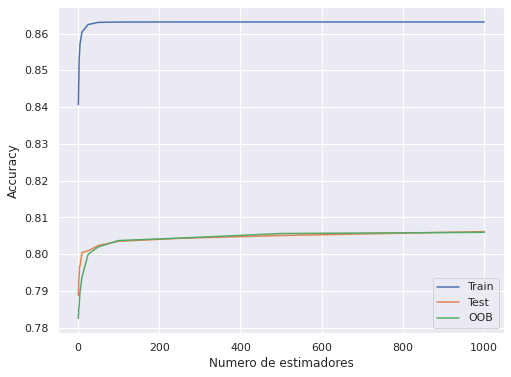

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(N_estimadores, train_accuracy, label = 'Train')
plt.plot(N_estimadores, test_accuracy, label = 'Test')
plt.plot(N_estimadores, oob_scores, label = 'OOB')
plt.xlabel('Numero de estimadores')
plt.ylabel('Accuracy')
plt.legend()
# plt.xlim(0,50)
plt.show()

8. Hacer y graficar la curva de aprendizaje para un modelo con 250 estimadores. Puede llevar bastante tiempo, no se preocupen.

In [ ]:
clf = RandomForestClassifier(n_estimators=250, n_jobs=-1, oob_score= True, random_state = 42)
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(clf, X_train, y_train, 
                                                         train_sizes = np.linspace(0.0001,1,10),
                                                         scoring = 'accuracy', cv=5)

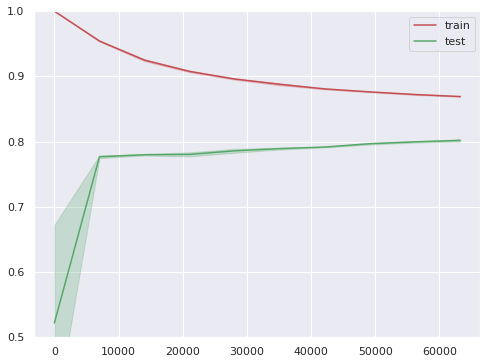

In [ ]:

plt.figure(figsize = (8,6))
plt.plot(train_sizes, train_scores.mean(axis = 1), color = 'r',label='train')
plt.plot(train_sizes, valid_scores.mean(axis = 1), color = 'g',label='test')

plt.fill_between(train_sizes, train_scores.mean(axis = 1)- train_scores.std(axis = 1),
                     train_scores.mean(axis = 1)+ train_scores.std(axis = 1), alpha=0.25,
                     color="r")
plt.fill_between(train_sizes, valid_scores.mean(axis = 1) - valid_scores.std(axis = 1),
                     valid_scores.mean(axis = 1) + valid_scores.std(axis = 1), alpha=0.25, color="g")
plt.legend()
plt.ylim(0.5,1)
plt.show()

9. Si usaron dos features, pueden graficar las fronteras de decisión.

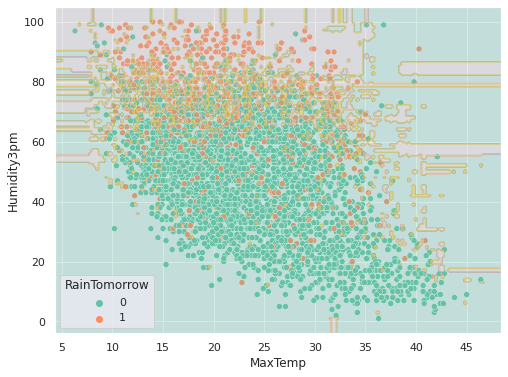

In [ ]:
N = 20 #para no graficar todos los puntos y saturar el grafico
clf = RandomForestClassifier(n_estimators=250).fit(X_train, y_train)

N = 10 #para no graficar todos los puntos y saturar el grafico

plt.figure(figsize = (8,6))

#Grafico Clasificador Sesgado
ax = sns.scatterplot(X_test[::N].MaxTemp, X_test[::N].Humidity3pm, hue=y_test[::N], palette='Set2')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                      np.linspace(*ylim, num=200))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
contours = ax.contourf(xx, yy, Z, alpha=0.3, cmap = 'Set2')

plt.show()

--------


**Ejercicio**: elegir más features y volver a entrenar.

**Para pensar**: ¿qué otras métricas utilizarían para evaluar estos modelos, dadas las características particulares del problema? Comparar con los casos *benchmark* que hicieron.

Dado que es un problema donde se quiere predecir si llovera o no, la precisión o el recall son metricas a considerar

In [75]:
X = Data.drop(columns=['RainTomorrow'])
print(X.head())
y = Data.RainTomorrow
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)

   MinTemp  MaxTemp  Rainfall  ...  Humidity3pm  Pressure9am  Temp3pm
0     13.4     22.9       0.6  ...         22.0       1007.7     21.8
1      7.4     25.1       0.0  ...         25.0       1010.6     24.3
2     12.9     25.7       0.0  ...         30.0       1007.6     23.2
3      9.2     28.0       0.0  ...         16.0       1017.6     26.5
4     17.5     32.3       1.0  ...         33.0       1010.8     29.7

[5 rows x 10 columns]


In [77]:
clf = RandomForestClassifier(n_estimators=10, max_features='auto', n_jobs=-1, oob_score = True, random_state = 42)
clf.fit(X_train,y_train)

#hacen seleccion de atributos e instancias

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

3. Evaluar su desempeño en el conjunto de train y de test.

In [78]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_train_pred, y_train))
print(metrics.accuracy_score(y_test_pred, y_test))

#tiende a 1 el train.. pareceria que tiende a overfiting pero como el test tambien crece entonces quiere decir que mejoro la performance a pesar de eso.

0.9855022961023189
0.8434382194934766


4. ¿Cuál es su `oob_score_`?¿Y que son `feature_importances_`?

In [79]:
clf.oob_score_  #out of bag score. agrega esta predicción para evaluar la performance en el modelo.

#es el score que devuelve con las instancias que no selecciono en el boostrap.
#usa instancias como si no las vio.
#pero siempre es mejor ver el score con los datos de test, porque el obb usa datos train.

0.8207775121130466

In [80]:
clf.feature_importances_   #la importancia de los features
#el atributo que tiene mas imporatncia. da informacion para ese modelo que atributo fue mas importante. Pero no es causal, sino lo que aprendio cual fue el atributo mas importante para ese modelo.
#en arboles de desicion se hace incapie en como se eligen sino se usa permutation importation.

array([0.08780785, 0.08269249, 0.08490925, 0.09179107, 0.05555686,
       0.05773871, 0.09360898, 0.25060384, 0.11096742, 0.08432353])

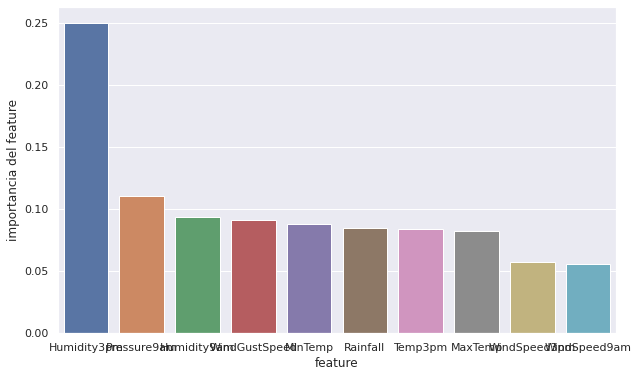

In [81]:
# CORRER ESTA CELDA UNA VEZ QUE HAYAN ESTUDIADO QUE ES OOB_SCORE Y FEATURE_IMPORTANCES
#se grafica lo que devuelve el feature_importance
importances = clf.feature_importances_
columns = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize = (10,6))
sns.barplot(columns[indices], importances[indices])
plt.xlabel('feature')
plt.ylabel('importancia del feature')
plt.show()

5. ¿Qué hay en la propiedad `estimators_`?

In [85]:
clf.estimators_ #muestra los distintos arboles que se usaron en el bosque

[DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=1608637542, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=1273642419, splitter='best'),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, 

6. Elegir uno de los `estimators` y evaluar su desempeño sobre train y test.

In [86]:
clf_tree = clf.estimators_[0]
clf_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 1608637542,
 'splitter': 'best'}

In [87]:
y_train_pred = clf_tree.predict(X_train)
y_test_pred = clf_tree.predict(X_test)
print(metrics.accuracy_score(y_train, y_train_pred))
print(metrics.accuracy_score(y_test, y_test_pred))

#acc train randomforest 0.9855022961023189
#acc test randomforest 0.8434382194934766
print(metrics.classification_report(y_test, y_test_pred))

0.9189722570116513
0.7781746266013342
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     26372
           1       0.50      0.51      0.50      7506

    accuracy                           0.78     33878
   macro avg       0.68      0.68      0.68     33878
weighted avg       0.78      0.78      0.78     33878



¿Está overfiteado?¿Por qué la accuracy sobre el conjunto de train no es 1?

cada arbol tiende al sobreentrenamiento por hipotesis. el random baja la varianza y por ende el score en test mejora. pero a mayor feature tiende a sobre estimar también.


7. Hacer y graficar la curva de validación/complejidad para un modelo Random Forest en función del número de estimadores. No usamos CV porque puede llevar bastante tiempo. Si quieren, lo pueden probar después. Además, obtener su oob_score para graficar en la curva de complejidad (No se preocupen por los mensajes de warning).

In [88]:
train_accuracy = []
test_accuracy = []
oob_scores = []

N_estimadores = [1,2,3,4,5,10,25,50,100,250,500,1000]
for estimadores in N_estimadores:
    print(estimadores)
    clf = RandomForestClassifier(n_estimators=estimadores, n_jobs=-1, oob_score= True, random_state = 42)
    clf.fit(X_train,y_train)
    
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    train_accuracy.append(metrics.accuracy_score(y_train, y_train_pred))
    test_accuracy.append(metrics.accuracy_score(y_test, y_test_pred))
    oob_scores.append(clf.oob_score_ )
    
train_accuracy = np.array(train_accuracy)
test_accuracy = np.array(test_accuracy)
oob_scores = np.array(oob_scores)

1
2
3
4
5
10
25
50
100
250
500
1000


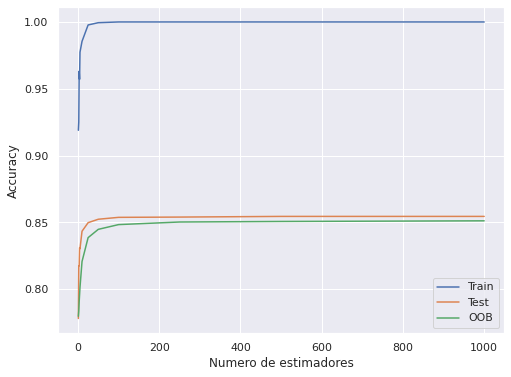

In [89]:
plt.figure(figsize = (8,6))
plt.plot(N_estimadores, train_accuracy, label = 'Train')
plt.plot(N_estimadores, test_accuracy, label = 'Test')
plt.plot(N_estimadores, oob_scores, label = 'OOB')
plt.xlabel('Numero de estimadores')
plt.ylabel('Accuracy')
plt.legend()
# plt.xlim(0,50)
plt.show()

#puedo ver cuantos estimadores le puedo poner para al randomfores que sea lo optimo

8. Hacer y graficar la curva de aprendizaje para un modelo con 250 estimadores. Puede llevar bastante tiempo, no se preocupen.

In [ ]:
clf = RandomForestClassifier(n_estimators=250, n_jobs=-1, oob_score= True, random_state = 42)
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(clf, X_train, y_train, 
                                                         train_sizes = np.linspace(0.0001,1,10),
                                                         scoring = 'accuracy', cv=5)

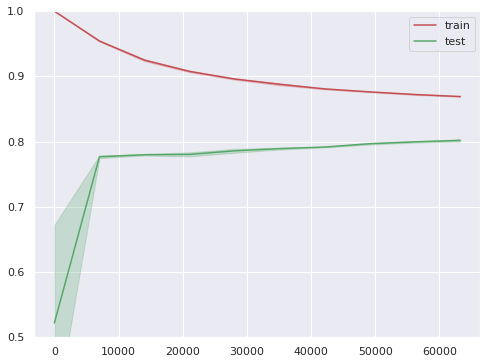

In [ ]:

plt.figure(figsize = (8,6))
plt.plot(train_sizes, train_scores.mean(axis = 1), color = 'r',label='train')
plt.plot(train_sizes, valid_scores.mean(axis = 1), color = 'g',label='test')

plt.fill_between(train_sizes, train_scores.mean(axis = 1)- train_scores.std(axis = 1),
                     train_scores.mean(axis = 1)+ train_scores.std(axis = 1), alpha=0.25,
                     color="r")
plt.fill_between(train_sizes, valid_scores.mean(axis = 1) - valid_scores.std(axis = 1),
                     valid_scores.mean(axis = 1) + valid_scores.std(axis = 1), alpha=0.25, color="g")
plt.legend()
plt.ylim(0.5,1)
plt.show()

9. Si usaron dos features, pueden graficar las fronteras de decisión.

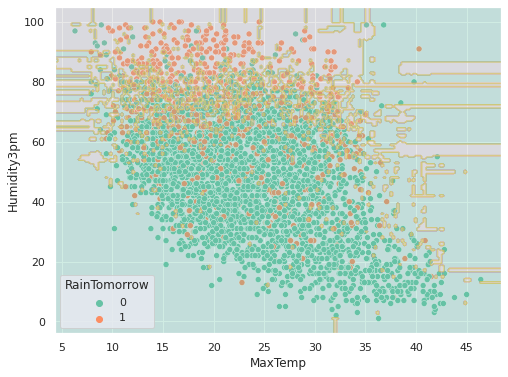

In [ ]:
N = 20 #para no graficar todos los puntos y saturar el grafico
clf = RandomForestClassifier(n_estimators=250).fit(X_train, y_train)

N = 10 #para no graficar todos los puntos y saturar el grafico

plt.figure(figsize = (8,6))

#Grafico Clasificador Sesgado
ax = sns.scatterplot(X_test[::N].MaxTemp, X_test[::N].Humidity3pm, hue=y_test[::N], palette='Set2')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                      np.linspace(*ylim, num=200))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
contours = ax.contourf(xx, yy, Z, alpha=0.3, cmap = 'Set2')

plt.show()